# Step 1. 데이터 다운로드

---------------------------------------

아래 링크에서 `korean-english-park.train.tar.gz`를 다운로드받아 한영 병렬 데이터를 확보합니다.

* [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

In [1]:
from requests import get
import os

os.mkdir('./data')

def download(url, file_name):
    with open(file_name, "wb") as file:   
        response = get(url)
        file.write(response.content)
        
url = 'https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1'
file_name = 'korean-english-park.train.tar.gz'

download(f'{url}/{file_name}', f'./data/{file_name}')

In [2]:
os.listdir('./data')

['korean-english-park.train.tar.gz']

In [3]:
import tarfile

with tarfile.open(f'./data/{file_name}') as tar:
    tar.extractall("./data")

In [4]:
os.listdir('./data')

['korean-english-park.train.ko',
 'korean-english-park.train.en',
 'korean-english-park.train.tar.gz']

# Step 2. 데이터 정제

---------------------------------------

1. `set` 데이터형이 **중복을 허용하지 않는다는 것을 활용**해 중복된 데이터를 제거하도록 합니다. 데이터의 **병렬 쌍이 흐트러지지 않게 주의**하세요! 중복을 제거한 데이터를 `cleaned_corpus` 에 저장합니다.

In [5]:
def load_file(file_name):
    with open(f'./data/{file_name}', "r") as f:
        result = f.read().splitlines()

    return result

In [6]:
kor_raw = load_file('korean-english-park.train.ko')
en_raw = load_file('korean-english-park.train.en')

len(kor_raw), len(en_raw)

(94123, 94123)

In [7]:
dataset = zip(kor_raw, en_raw)

cleaned_corpus = set(dataset)

2. 앞서 정의한 `preprocessing()`함수는 한글에서는 동작하지 않습니다. **한글에 적용할 수 있는 정규식**을 추가하여 함수를 재정의하세요!

In [8]:
import re

def preprocess_sentence(sentence, s_token=False, e_token=False):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

3. 타겟 언어인 영문엔 `<start>`토큰과 `<end>`토큰을 추가하고 `split()`함수를 이용하여 토큰화합니다. 

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. `cleaned_corpus`로부터 토큰의 길이가 40 이하인 데이터를 선별하여 `eng_corpus`와 `kor_corpus`를 각각 구축하세요.

In [9]:
# def set_preprocess(it):
#     return (
#         preprocess_sentence(it[0]),
#         preprocess_sentence(it[1], s_token=True, e_token=True)
#     )

# preprocessed_set = map(set_preprocess, list(cleaned_corpus))
# filted_set = filter(lambda it: len(it[0]) <= 40, preprocessed_set)

kor_corpus = []
eng_corpus = []

for kor, eng in cleaned_corpus:
    _kor = preprocess_sentence(kor)
    
    if len(_kor) <= 40 and len(_kor) >= 5:
        kor_corpus.append(_kor)
        
        _eng = preprocess_sentence(eng, s_token=True, e_token=True)
        eng_corpus.append(_eng)

In [10]:
len(kor_corpus), len(eng_corpus)

(16345, 16345)

In [11]:
print("Korean:", kor_corpus[50])   
print("English:", eng_corpus[50])  

Korean: 호킨스는 지난 여름 미군에 자원입대했지만 거절됐다 .
English: <start> this past summer hawkins tried to enlist in the u . s . army but was turned down a source familiar with the situation told cnn . <end>


In [12]:
print("Korean:", kor_corpus[100])   
print("English:", eng_corpus[100])  

Korean: 주한 미군 분의 로 감축 예정 .
English: <start> the u . s . troops in korea will cut the number by one third . <end>


In [13]:
print("Korean:", kor_corpus[150])   
print("English:", eng_corpus[150])  

Korean: 경기침체는 몇몇 구두쇠들을 새로운 극단주의에 이르도록 만들고 있습니다 .
English: <start> the recession is leading some people to take the art of being a tightwad to new extremes . <end>


In [14]:
print("Korean:", kor_corpus[200])   
print("English:", eng_corpus[200])  

Korean: 워싱턴에서 브라이언 토마스 기자입니다 .
English: <start> brian thomas washington . <end>


# Step 3. 데이터 토큰화

---------------------------------------

앞서 정의한 `tokenize()`함수를 사용해 데이터를 텐서로 변환하고 각각의 `tokenizer`를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

❗ 주의: 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.

* 한글 토큰화는 KoNLPy의 `mecab`클래스를 사용합니다.

In [15]:
from konlpy.tag import Mecab
import tensorflow as tf

def tokenize(corpus, is_kor=True):
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    
    if is_kor:
        mecab = Mecab()
        corpus = [' '.join(mecab.morphs(sen)) for sen in corpus]
        
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    
    if is_kor:
        tensor = [list(reversed(sen)) for sen in tensor]
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=40)
    else:
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=40)
        
    return tensor, tokenizer

In [16]:
kor_tensor, kor_tokenizer = tokenize(kor_corpus, is_kor=True)
eng_tensor, eng_tokenizer = tokenize(eng_corpus, is_kor=False)

print(f'Korean Vocab Size: {len(kor_tokenizer.index_word)}')
print(f'English Vocab Size: {len(eng_tokenizer.index_word)}')

Korean Vocab Size: 17584
English Vocab Size: 16941


In [17]:
from sklearn.model_selection import train_test_split

kor_train, kor_test, eng_train, eng_test = train_test_split(kor_tensor, eng_tensor, test_size=0.2)

len(kor_train), len(kor_test), len(eng_train), len(eng_test)

(13076, 3269, 13076, 3269)

# Step 4. 모델 설계

---------------------------------------

한국어를 영어로 잘 번역해 줄 멋진 **Attention 기반 Seq2seq 모델을 설계**하세요! 앞서 만든 모델에 `Dropout`모듈을 추가하면 성능이 더 좋아집니다! `Embedding Size`와 `Hidden Size`는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

In [18]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__() 
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [19]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)
        
        self.dropout = tf.keras.layers.Dropout(rate=0.2)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        out = self.dropout(out)
        
        return out

In [20]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)
        
        self.dropout = tf.keras.layers.Dropout(rate=0.2)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = self.dropout(out)
        
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [21]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import re
import numpy as np


class TranslateModel():
    def __init__(self, enc_tokenizer, dec_tokenizer, batch_size=64, units=1024, embedding_dim=512, epochs=10):
        super(TranslateModel, self).__init__()
        
        self.enc_tokenizer = enc_tokenizer
        self.dec_tokenizer = dec_tokenizer
        
        self.BATCH_SIZE = batch_size
        self.units = units
        self.embedding_dim = embedding_dim
        
        SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
        TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1
            
        self.encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
        self.decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        
        self.EPOCHS = epochs
        
        self.enc_shape = None
        self.dec_shape = None
                  
            
    def summary(self):
        
        sequence_len = 40

        sample_enc = tf.random.uniform((self.BATCH_SIZE, sequence_len))
        sample_output = self.encoder(sample_enc)

        print ('Encoder Output:', sample_output.shape)

        sample_state = tf.random.uniform((self.BATCH_SIZE, self.units))

        sample_logits, h_dec, attn = self.decoder(
            tf.random.uniform((self.BATCH_SIZE, 1)), 
            sample_state, 
            sample_output)

        print ('Decoder Output:', sample_logits.shape)
        print ('Decoder Hidden State:', h_dec.shape)
        print ('Attention:', attn.shape)
        
    
    def loss_function(self, real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss = self.loss_object(real, pred)

        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask

        return tf.reduce_mean(loss)
    
    
    @tf.function
    def train_step(self, src, tgt):
        bsz = src.shape[0]
        loss = 0

        with tf.GradientTape() as tape:
            enc_out = self.encoder(src)
            h_dec = enc_out[:, -1]

            dec_src = tf.expand_dims([self.dec_tokenizer.word_index['<start>']] * bsz, 1)

            for t in range(1, tgt.shape[1]):
                pred, h_dec, _ = self.decoder(dec_src, h_dec, enc_out)

                loss += self.loss_function(tgt[:, t], pred)
                dec_src = tf.expand_dims(tgt[:, t], 1)

        batch_loss = (loss / int(tgt.shape[1]))

        variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss
    
    
    @tf.function
    def eval_step(self, src, tgt):
        bsz = src.shape[0]
        loss = 0

        enc_out = self.encoder(src)

        h_dec = enc_out[:, -1]

        dec_src = tf.expand_dims([self.dec_tokenizer.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = self.decoder(dec_src, h_dec, enc_out)

            loss += self.loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)

        batch_loss = (loss / int(tgt.shape[1]))

        return batch_loss
    
    
    def train(self, enc_train, enc_test, dec_train, dec_test):
        
        self.enc_shape = enc_train.shape[-1]
        self.dec_shape = dec_train.shape[-1]
        
        for epoch in range(self.EPOCHS):
            total_loss = 0
            
            idx_list = list(range(0, enc_train.shape[0], self.BATCH_SIZE))
            random.shuffle(idx_list)
            t = tqdm(idx_list)
            
            for (batch, idx) in enumerate(t):
                src = enc_train[idx:idx+self.BATCH_SIZE]
                tgt = dec_train[idx:idx+self.BATCH_SIZE]
                
                batch_loss = self.train_step(src, tgt)
                total_loss += batch_loss

                t.set_description_str('Epoch %2d' % (epoch + 1))
                t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
                
            test_loss = 0
            
            idx_list = list(range(0, enc_test.shape[0], self.BATCH_SIZE))
            random.shuffle(idx_list)
            t = tqdm(idx_list)
            
            for (test_batch, idx) in enumerate(t):
                src = enc_test[idx:idx+self.BATCH_SIZE]
                tgt = dec_test[idx:idx+self.BATCH_SIZE]
                
                test_batch_loss = self.eval_step(src, tgt)
                test_loss += test_batch_loss

                t.set_description_str('Test Epoch %2d' % (epoch + 1))
                t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))
            
            
    def evaluate(self, sentence):
        attention = np.zeros((self.dec_shape, self.enc_shape))
        
        sentence = sentence.lower().strip()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
        sentence = sentence.strip()
        
        inputs = self.enc_tokenizer.texts_to_sequences([sentence.split()])
        inputs = [list(reversed(sen)) for sen in inputs]
        inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=self.enc_shape, padding='pre')
        
        result = ''

        enc_out = self.encoder(inputs)

        dec_hidden = enc_out[:, -1]
        dec_input = tf.expand_dims([self.dec_tokenizer.word_index['<start>']], 0)
        
        for t in range(self.dec_shape):
            predictions, dec_hidden, attention_weights = self.decoder(dec_input, dec_hidden, enc_out)

            attention_weights = tf.reshape(attention_weights, (-1, ))
            attention[t] = attention_weights.numpy()

            predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

            result += self.dec_tokenizer.index_word[predicted_id] + ' '

            if self.dec_tokenizer.index_word[predicted_id] == '<end>':
                return result, sentence, attention

            dec_input = tf.expand_dims([predicted_id], 0)

        return result, sentence, attention
    
    
    def plot_attention(self, attention, sentence, predicted_sentence):
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(1, 1, 1)
        ax.matshow(attention, cmap='viridis')

        fontdict = {'fontsize': 14}

        ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
        ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        plt.show()
        
    
    def translate(self, sentence):
        result, sentence, attention = self.evaluate(sentence)

        print('Input: %s' % (sentence))
        print('Predicted translation: {}'.format(result))

        attention = attention[:len(result.split()), :len(sentence.split())]
        self.plot_attention(attention, sentence.split(), result.split(' '))

# Step 5. 훈련하기

---------------------------------------

훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

❕ 참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있습니다.

In [22]:
model = TranslateModel(
    kor_tokenizer, eng_tokenizer, 
    batch_size=64, units=512, embedding_dim=1024, epochs=50)

model.summary()

Encoder Output: (64, 40, 512)
Decoder Output: (64, 16942)
Decoder Hidden State: (64, 512)
Attention: (64, 40, 1)


In [23]:
model.train(kor_train, kor_test, eng_train, eng_test)

Test Epoch 50: 100%|██████████| 52/52 [00:03<00:00, 13.11it/s, Test Loss 2.4996]


In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

/tmp/ipykernel_263/2802984494.py:198: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_263/2802984494.py:199: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Input: 인생도 회처럼 날로 먹고싶다 .
Predicted translation: . . <end> 


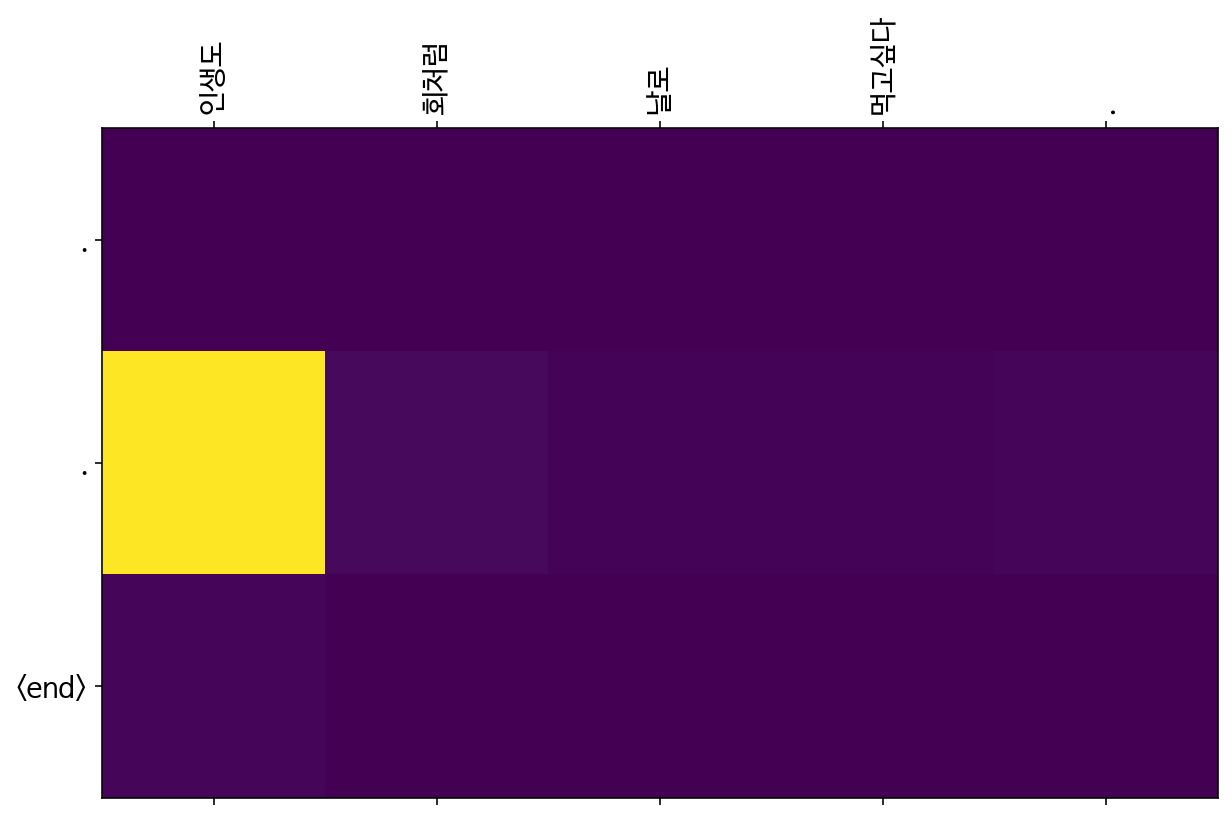

In [25]:
model.translate('인생도 회처럼 날로 먹고싶다.')

Input: 무슨 영화 좋아하세요 ? 부귀영화요
Predicted translation: we have to have a lot of your life <end> 


/tmp/ipykernel_263/2802984494.py:198: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_263/2802984494.py:199: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


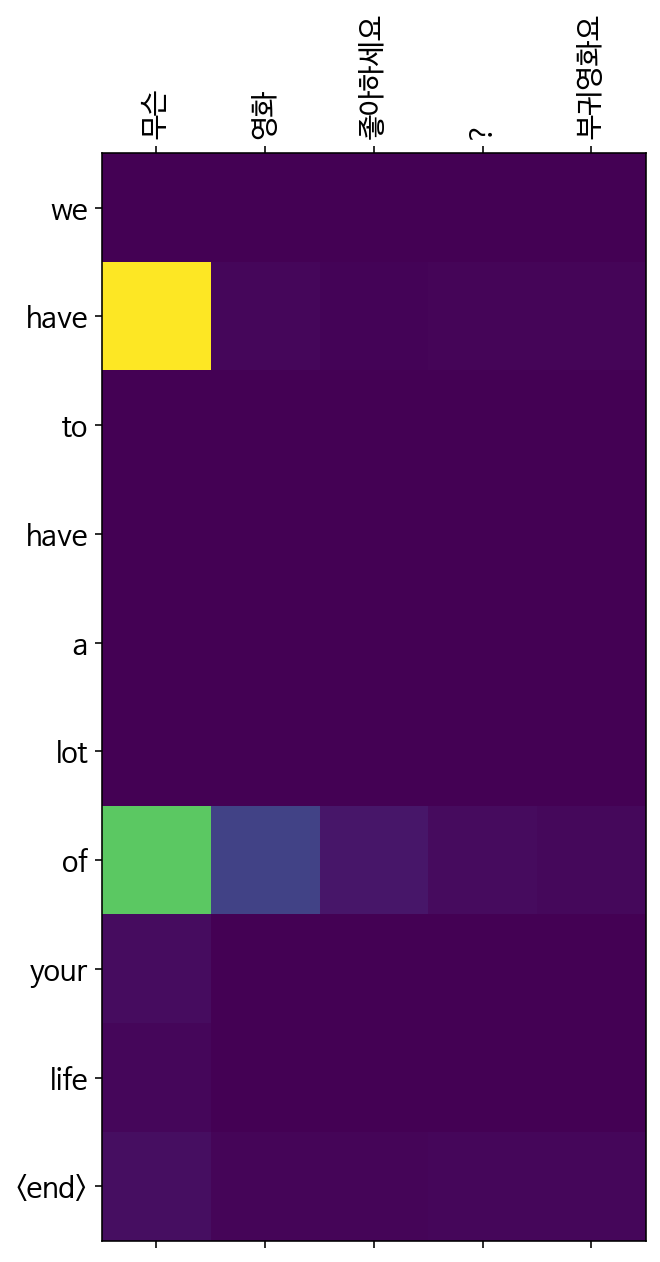

In [26]:
model.translate('무슨 영화 좋아하세요? 부귀영화요')

Input: 말하기 전에 생각했나요 ?
Predicted translation: rita foley <end> 


/tmp/ipykernel_263/2802984494.py:198: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_263/2802984494.py:199: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


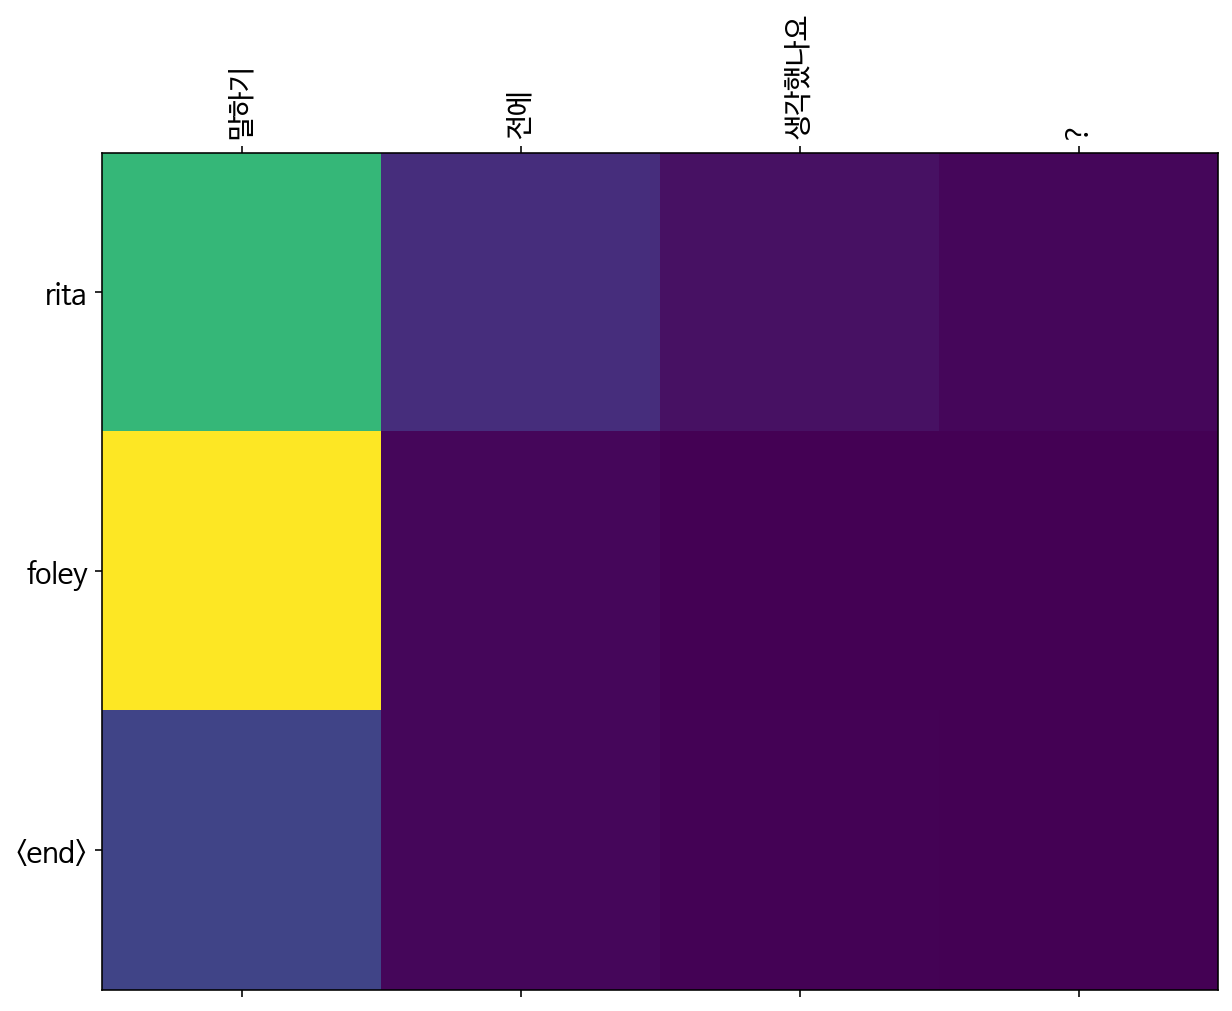

In [27]:
model.translate('말하기 전에 생각했나요?')

Input: 성능 똥같네 이게 맞나 ?
Predicted translation: bad cnn doom and rolex <end> 


/tmp/ipykernel_263/2802984494.py:198: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_263/2802984494.py:199: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


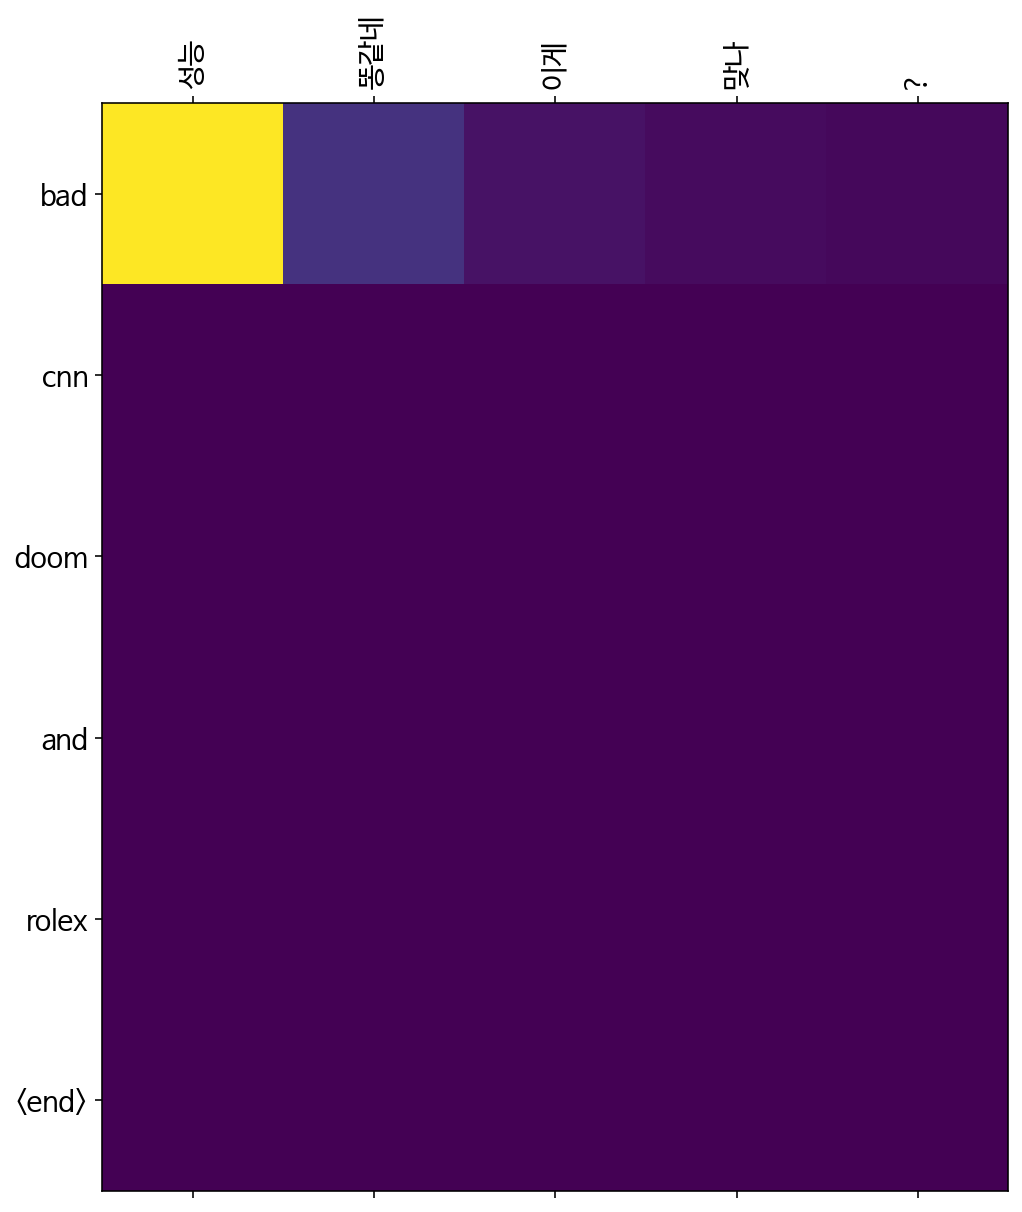

In [28]:
model.translate('성능 똥같네, 이게 맞나?')

# 회고

---------------------------------------

## 어려웠던 부분

* 데이터셋 자체에 문제가 있는것이 아닌가 의심이 